<a href="https://colab.research.google.com/github/Tejaswini-Gsl/neural-networks/blob/main/model(domain).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
import librosa as lr
import shutil
import dask.array as da
import h5py
import glob
# import resampy
import imageio
from PIL import Image


importing datasets

In [2]:
# importing english dataset

other_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/en/other.tsv', sep='\t')
validate_sen_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/en/validated.tsv', sep='\t')
unvalidate_sen_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/en/invalidated.tsv', sep='\t')

other_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/other.tsv', sep='\t')
validate_sen_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/validated.tsv', sep='\t')
unvalidate_sen_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/invalidated.tsv', sep='\t')

print(validate_sen_df_en.shape,validate_sen_df_ca.shape)
print("values of en:",other_df_en['sentence_domain'].notnull().sum(),validate_sen_df_en['sentence_domain'].notnull().sum(),unvalidate_sen_df_en['sentence_domain'].notnull().sum())
print("values of ca:",other_df_ca['sentence_domain'].notnull().sum(),validate_sen_df_ca['sentence_domain'].notnull().sum(),unvalidate_sen_df_ca['sentence_domain'].notnull().sum())

(1877, 13) (1586, 13)
values of en: 102 1 1
values of ca: 219 2 0


In [3]:
# unique_values = other_df_en.loc[other_df_en['sentence_domain'].notnull(), 'sentence_domain'].unique()

# unique_values_ca = other_df_ca.loc[other_df_ca['sentence_domain'].notnull(), 'sentence_domain'].unique()
# print(unique_values,unique_values_ca)

data preprocessing

In [4]:
def cleaned_data(other_df,validate_sen_df,unvalidate_sen_df,lan): # combining different df wrt language(en,ca)
  other_df_cleaned = other_df.dropna(subset=['sentence_domain'], inplace=False)
  validate_sen_df_cleaned = validate_sen_df.dropna(subset=['sentence_domain'], inplace=False)
  unvalidate_sen_df_cleaned = unvalidate_sen_df.dropna(subset=['sentence_domain'], inplace=False)
  print(other_df_cleaned.shape,validate_sen_df_cleaned.shape,unvalidate_sen_df_cleaned.shape)
  result = pd.concat([other_df_cleaned,validate_sen_df_cleaned,unvalidate_sen_df_cleaned], axis=0)
  print(result.shape)
  file_path = "/content/drive/MyDrive/neural dataset/{}/other_cleaned.tsv".format(lan)
  result.to_csv(file_path, sep='\t', index=False)
  return(result)

df_en = cleaned_data(other_df_en,validate_sen_df_en,unvalidate_sen_df_en,'en')
df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/other_cleaned.tsv', sep='\t') #[:102]
df_ca.shape

(102, 13) (1, 13) (1, 13)
(104, 13)


(221, 13)

(optional) moving mp3 files to different folders based on path

In [5]:
# import os
# import shutil

# def allclips(df,lan):
#   # Source folder containing the MP3 files

#   path = '/content/drive/MyDrive/neural dataset/{}/clips'.format(lan)
#   source_folder = path

#   # Destination folder where MP3 files will be moved
#   destination_folder = '/content/drive/MyDrive/neural dataset/allclips'

#   # Create destination folder if it doesn't exist
#   os.makedirs(destination_folder, exist_ok=True)

#   # Loop through each row in the DataFrame
#   for index, row in df.iterrows():
#       # Extract the MP3 file name from the 'path' column
#       mp3_file = os.path.basename(row['path'])

#       # Construct the full path of the MP3 file in the source folder
#       source_path = os.path.join(source_folder, mp3_file)

#       # Construct the full path of the MP3 file in the destination folder
#       destination_path = os.path.join(destination_folder, mp3_file)

#       # Check if the MP3 file exists in the source folder
#       if os.path.exists(source_path):
#           # Move the MP3 file from the source folder to the destination folder
#           shutil.move(source_path, destination_path)
#           print(f"Moved {mp3_file} to {destination_folder}")
#       else:
#           print(f"MP3 file {mp3_file} not found in the source folder")

#   print("All MP3 files have been moved.")


# allclips(df_en,'en')
# # allclips(df_de,'de')


In [6]:
df_total = pd.concat([df_en,df_ca], axis=0)  # combining language(en,ca) df into
df_total.head(1)

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment
31964,044c70753ccd50c9bf6711e2344eb264c8ef5064960e38...,common_voice_en_40031175.mp3,806fb5a822d00a7181769805509a97076ff51bf252dd06...,I would like to install Alpine Linux on my com...,technology_robotics,0,0,NaN,NaN,NaN,NaN,en,NaN


In [7]:
def load_audio(file_path, sr=16000): #Load an audio file into an array.
    data,sr = lr.load(file_path)
    return data


df_total['audio'] = df_total['path'].apply(lambda x: load_audio(f'/content/drive/MyDrive/neural dataset/allclips/{x}'))

In [8]:
import librosa as lr

# def extract_features(audio, n_mfcc=13, hop_length=512, n_fft=2048):
#     mfcc = lr.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc,
#                            hop_length=hop_length, n_fft=n_fft)
#     return mfcc.T  # Transpose to align time to rows
# df_total['features'] = df_total['audio'].apply(extract_features)


# Extract mel spectrogram features from an audio signal.
def extract_features(audio, n_mels=128, hop_length=512, n_fft=2048):
    mel_spectrogram = lr.feature.melspectrogram(y=audio, sr=16000, n_mels=n_mels,
                                                hop_length=hop_length, n_fft=n_fft)
    return mel_spectrogram.T  # Transpose to align time to rows

# Assuming df_total['audio'] contains the audio data
df_total['features'] = df_total['audio'].apply(extract_features)

# Print the shapes of the extracted features
print(df_total['features'][0].shape)  # Assuming you want to check the shape of the first sample



(109, 128)


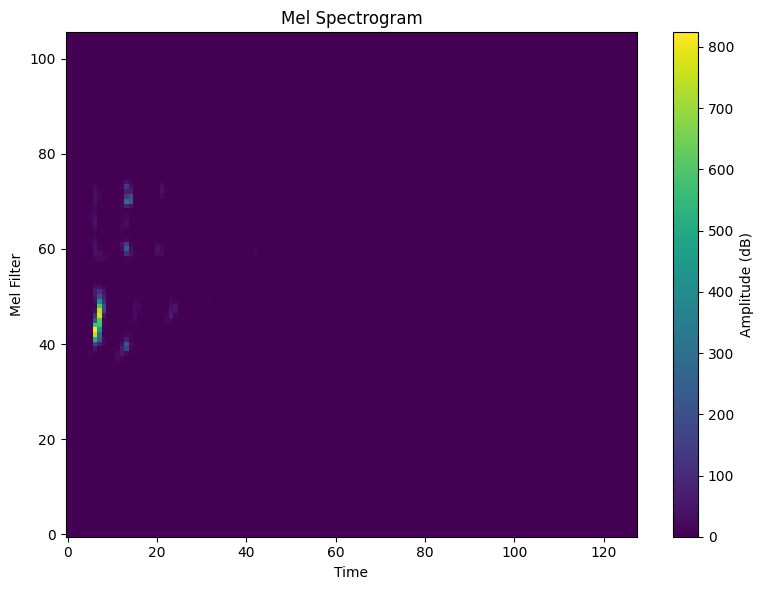

In [23]:
import matplotlib.pyplot as plt

# Assuming df_total['features'] contains the extracted mel spectrogram features
# Choose an index of the audio file you want to visualize
index = 150

# Plot the mel spectrogram
plt.figure(figsize=(8, 6))
plt.imshow(df_total['features'][index], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Filter')
plt.tight_layout()
plt.show()


Mean mel-spectrogram length: 180.55
Median mel-spectrogram length: 165.0
90th percentile mel-spectrogram length: 272.6
95th percentile mel-spectrogram length: 318.80000000000007


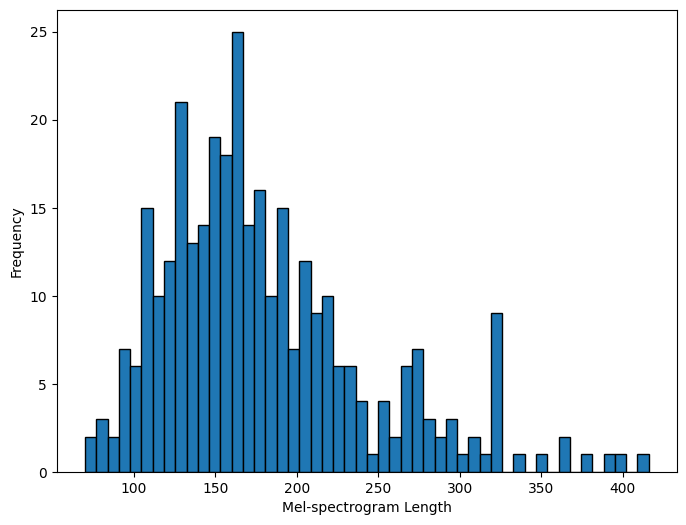

In [25]:

features_lengths = []
for features in df_total['features']:
    features_lengths.append(features.shape[0])

# Calculate statistics
mean_length = np.mean(features_lengths)
median_length = np.median(features_lengths)
percentile_90 = np.percentile(features_lengths, 90)
percentile_95 = np.percentile(features_lengths, 95)

print(f"Mean mel-spectrogram length: {mean_length:.2f}")
print(f"Median mel-spectrogram length: {median_length}")
print(f"90th percentile mel-spectrogram length: {percentile_90}")
print(f"95th percentile mel-spectrogram length: {percentile_95}")

# Plot a histogram
plt.figure(figsize=(8, 6))
plt.hist(features_lengths, bins=50, edgecolor='black')
plt.xlabel('Mel-spectrogram Length')
plt.ylabel('Frequency')
# plt.title('Distribution of Mel-spectrogram Lengths')
plt.show()

In [28]:

# Assuming you have a maximum length for the features
max_length = 256  # Replace with the desired maximum length based on percentile mel-spectrogram length

# Define a padding function
def pad_features(features, max_length):
    padded_features = np.zeros((max_length, features.shape[1]))
    if features.shape[0] > max_length:
        padded_features = features[:max_length, :]
    else:
        padded_features[:features.shape[0], :] = features
    return padded_features

# Pad the features in the dataframes
df_total['features'] = df_total['features'].apply(lambda x: pad_features(x, max_length))
# Now you can convert the features to NumPy arrays
X = np.array(df_total['features'].tolist())
y_domain =(df_total['sentence_domain'])



In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# df_total['locale'] and df_total['sentence_domain'] are the columns with string labels
# Initialize label encoders
label_encoder_lang = LabelEncoder()
label_encoder_domain = LabelEncoder()

# Fit label encoder and return encoded labels
# y_lan = label_encoder_lang.fit_transform(df_total['locale'].dropna())
y_domain = label_encoder_domain.fit_transform(df_total['sentence_domain'].dropna())
# print(y_domain.shape)

# Get the number of classes from the fitted label encoder
# num_language_classes = len(label_encoder_lang.classes_)
num_domain_classes = len(label_encoder_domain.classes_)

# Convert labels to one-hot encoding
# y_lan_encoded = to_categorical(y_lan, num_classes=num_language_classes)
# y_lan_encoded.shape

y_domain_encoded = to_categorical(y_domain, num_classes=num_domain_classes)
y_domain_encoded.shape

(325, 11)

In [30]:
X.shape,y_domain_encoded.shape

((325, 256, 128), (325, 11))

train test split

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_domain_train, y_domain_test = train_test_split(
    X, y_domain_encoded, test_size=0.3, random_state=42
)

# Optionally, split the training set further to create a validation set (e.g., 80% of the remaining train for training, 20% for validation)
X_train, X_val, y_domain_train, y_domain_val = train_test_split(
    X_train, y_domain_train, test_size=0.2, random_state=42
)


# Check the shape of each set to ensure everything is correct
print("Training set:", X_train.shape, y_domain_train.shape)
print("Validation set:", X_val.shape, y_domain_val.shape)
print("Test set:", X_test.shape, y_domain_test.shape)

Training set: (181, 256, 128) (181, 11)
Validation set: (46, 256, 128) (46, 11)
Test set: (98, 256, 128) (98, 11)


In [32]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)/ 255.0
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)/ 255.0
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)/255.0

In [33]:
num_language_classes= 2
num_domain_classes = y_domain_test.shape[-1]
X_train.shape


(181, 256, 128, 1)

# Model 1 : CNN

In [34]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# Define the CNN model
def create_cnn_model(input_shape, num_domain_classes, num_language_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # First conv layer
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second conv layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third conv layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),



        # Flatten the output of the conv layers to feed into the dense layer
        layers.Flatten(),

        # Dense layer for feature interpretation
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        # Separate output layers for domain classification
        # layers.Dense(num_language_classes, activation='softmax'),
        layers.Dense(num_domain_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Assuming you have already defined input_shape, num_domain_classes, and num_language_classes
input_shape = X_train[0].shape  # Example: (MFCC_Time, MFCC_Features, 1) e.g., (32, 13, 1)
print(input_shape)
# Create the model
model = create_cnn_model(input_shape, num_domain_classes, num_language_classes)

# Print the model summary
model.summary()


(256, 128, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 64, 32)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 64, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 64, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64, 32

In [35]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.6 MB/s eta 0:00:00


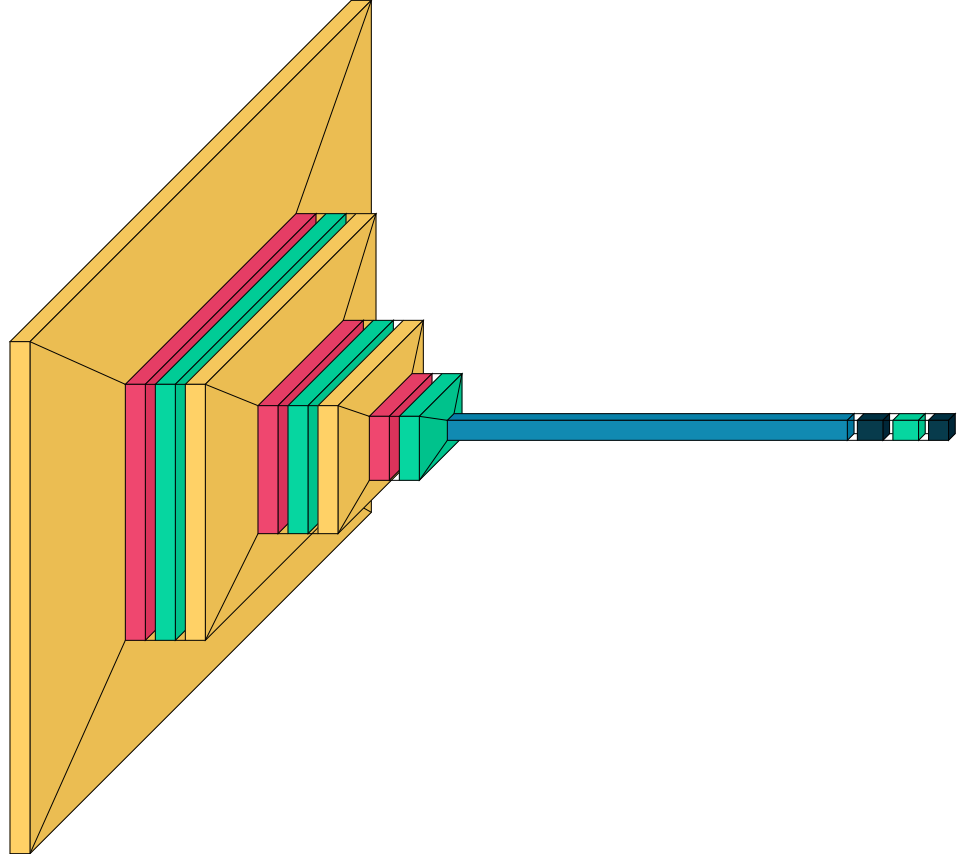

In [36]:
import visualkeras


visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [ ]:
# fit the model
history = model.fit(X_train, y_domain_train,epochs=20,validation_data=(X_val,y_domain_val), batch_size=32)

Epoch 1/20
6/6 [==============================] - 21s 3s/step - loss: 2.0203 - accuracy: 0.3867 - val_loss: 2.1198 - val_accuracy: 0.3478
Epoch 2/20
6/6 [==============================] - 28s 5s/step - loss: 1.8040 - accuracy: 0.4586 - val_loss: 2.0613 - val_accuracy: 0.3478
Epoch 3/20
6/6 [==============================] - 17s 3s/step - loss: 1.6975 - accuracy: 0.4641 - val_loss: 1.9795 - val_accuracy: 0.3478
Epoch 4/20
6/6 [==============================] - 20s 4s/step - loss: 1.6800 - accuracy: 0.4309 - val_loss: 2.0124 - val_accuracy: 0.3261
Epoch 5/20
6/6 [==============================] - 27s 4s/step - loss: 1.5848 - accuracy: 0.4530 - val_loss: 2.1699 - val_accuracy: 0.3478
Epoch 6/20
6/6 [==============================] - 17s 3s/step - loss: 1.5394 - accuracy: 0.4751 - val_loss: 2.4216 - val_accuracy: 0.3261
Epoch 7/20
6/6 [==============================] - 21s 3s/step - loss: 1.4759 - accuracy: 0.4751 - val_loss: 2.5877 - val_accuracy: 0.3261
Epoch 8/20
6/6 [==================

# Model 2 : RNN

In [ ]:
def create_rnn_model(input_shape, num_domain_classes, num_language_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # LSTM layer
        layers.LSTM(64, return_sequences=True),

        # Dropout layer
        layers.Dropout(0.5),

        # LSTM layer
        layers.LSTM(64),

        # Dropout layer
        layers.Dropout(0.5),

        # Dense layer for feature interpretation
        layers.Dense(256, activation='relu'),

        # Output layer for domain classification
        layers.Dense(num_domain_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape1=X_train.shape[1:-1]
model_rnn = create_rnn_model(input_shape1, num_domain_classes, num_language_classes)

model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256, 64)           49408     
                                                                 
 dropout_6 (Dropout)         (None, 256, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 11)                2827      
                                                                 
Total params: 101899 (398.04 KB)
Trainable params: 101

In [ ]:
# Fit the model
history_rnn = model_rnn.fit(X_train, y_domain_train,epochs=20,validation_data=(X_val,y_domain_val), batch_size=32)

Epoch 1/20
6/6 [==============================] - 2s 307ms/step - loss: 1.7714 - accuracy: 0.4420 - val_loss: 1.9567 - val_accuracy: 0.3478
Epoch 2/20
6/6 [==============================] - 2s 285ms/step - loss: 1.7450 - accuracy: 0.4420 - val_loss: 1.9362 - val_accuracy: 0.3478
Epoch 3/20
6/6 [==============================] - 2s 340ms/step - loss: 1.7450 - accuracy: 0.4420 - val_loss: 1.9441 - val_accuracy: 0.3478
Epoch 4/20
6/6 [==============================] - 3s 469ms/step - loss: 1.9054 - accuracy: 0.4420 - val_loss: 2.3840 - val_accuracy: 0.3478
Epoch 5/20
6/6 [==============================] - 2s 345ms/step - loss: 1.8290 - accuracy: 0.4420 - val_loss: 1.9555 - val_accuracy: 0.3478
Epoch 6/20
6/6 [==============================] - 2s 287ms/step - loss: 1.8237 - accuracy: 0.4254 - val_loss: 1.9683 - val_accuracy: 0.3478
Epoch 7/20
6/6 [==============================] - 2s 293ms/step - loss: 1.8142 - accuracy: 0.4365 - val_loss: 1.9465 - val_accuracy: 0.3478
Epoch 8/20
6/6 [====

# Model 3 : Transformer

In [ ]:
from tensorflow.keras import layers, models

def create_transformer_model(input_shape, num_domain_classes, num_language_classes):
    # Encoder
    encoder_inputs = layers.Input(shape=input_shape)
    encoder_dense = layers.Flatten()(encoder_inputs)
    encoder_dense = layers.Dense(128, activation='relu')(encoder_dense)
    encoder_dense = layers.Dropout(0.5)(encoder_dense)
    encoder_output = layers.Dense(128, activation='relu')(encoder_dense)

    # Decoder
    decoder_inputs = layers.Input(shape=input_shape)
    decoder_dense = layers.Flatten()(decoder_inputs)
    decoder_dense = layers.Dense(128, activation='relu')(decoder_dense)
    decoder_dense = layers.Dropout(0.5)(decoder_dense)
    decoder_output = layers.Dense(128, activation='relu')(decoder_dense)

    # Output layers
    output = layers.Concatenate()([encoder_output, decoder_output])
    output = layers.Dense(256, activation='relu')(output)
    output = layers.Dropout(0.5)(output)
    # language_output = layers.Dense(num_language_classes, activation='softmax')(output)
    domain_output = layers.Dense(num_domain_classes, activation='softmax')(output)

    # Build and compile the model
    model = models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=domain_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage
input_shape = X_train.shape[1:]  # Input shape for the encoder

print(input_shape)
# num_domain_classes = 10  # Number of domain classes
# num_language_classes = 2  # Number of language classes

model_ts = create_transformer_model(input_shape, num_domain_classes, num_language_classes)
model_ts.summary()


(256, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 128, 1)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 256, 128, 1)]        0         []                            
                                                                                                  
 flatten_1 (Flatten)         (None, 32768)                0         ['input_4[0][0]']             
                                                                                                  
 flatten_2 (Flatten)         (None, 32768)                0         ['input_5[0][0]']             
                                                                                

In [ ]:
# Fit the model
history_ts = model_ts.fit([X_train, X_train], y_domain_train, validation_data=([X_val, X_val], y_domain_val), epochs=20, batch_size=32)

Epoch 1/20
6/6 [==============================] - 2s 170ms/step - loss: 2.2733 - accuracy: 0.3425 - val_loss: 2.2381 - val_accuracy: 0.3478
Epoch 2/20
6/6 [==============================] - 1s 115ms/step - loss: 1.9662 - accuracy: 0.4420 - val_loss: 2.2894 - val_accuracy: 0.3478
Epoch 3/20
6/6 [==============================] - 1s 161ms/step - loss: 1.8805 - accuracy: 0.4475 - val_loss: 2.2282 - val_accuracy: 0.3478
Epoch 4/20
6/6 [==============================] - 1s 150ms/step - loss: 1.6670 - accuracy: 0.4641 - val_loss: 2.3246 - val_accuracy: 0.3478
Epoch 5/20
6/6 [==============================] - 1s 145ms/step - loss: 1.5089 - accuracy: 0.5028 - val_loss: 2.3922 - val_accuracy: 0.3261
Epoch 6/20
6/6 [==============================] - 1s 141ms/step - loss: 1.4560 - accuracy: 0.4972 - val_loss: 2.5377 - val_accuracy: 0.3478
Epoch 7/20
6/6 [==============================] - 1s 152ms/step - loss: 1.2868 - accuracy: 0.5470 - val_loss: 2.6365 - val_accuracy: 0.3043
Epoch 8/20
6/6 [====

Evaluation Models

In [ ]:
def eval_model(model, x, y, model_name):

    try:
        if model_name == 'Transformer':
            test_loss, test_accuracy = model.evaluate([x, x], y)
        else:
            test_loss, test_accuracy = model.evaluate(x, y)
        return test_loss, test_accuracy
    except Exception as e:
        print('Failed to evaluate model {}: {}'.format(model_name, e))
        return None, None

# Example usage and storing results:
results = {}
models = {'CNN': model, 'RNN': model_rnn, 'Transformer': model_ts}
for name, mod in models.items():
    loss, accuracy = eval_model(mod, X_test, y_domain_test, name)
    results[name] = (loss, accuracy)


4/4 [==============================] - 0s 15ms/step - loss: 4.0560 - accuracy: 0.4388


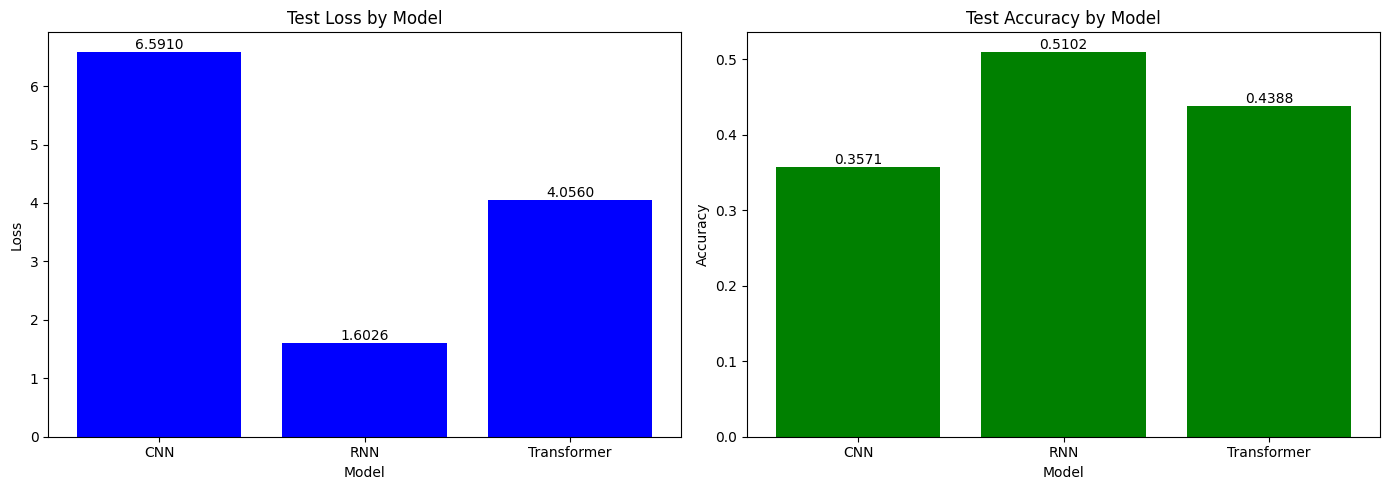

In [ ]:
import matplotlib.pyplot as plt

# Assuming `results` is a dictionary containing the loss and accuracy
labels = list(results.keys())
loss_values = [results[name][0] for name in labels]
accuracy_values = [results[name][1] for name in labels]

# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plotting loss
ax[0].bar(labels, loss_values, color='blue')
ax[0].set_title('Test Loss by Model')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Model')

# Plotting accuracy
ax[1].bar(labels, accuracy_values, color='green')
ax[1].set_title('Test Accuracy by Model')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Model')

# Adding a legend
for a in ax:
    for p in a.patches:
        a.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')

plt.tight_layout()
plt.show()
